## In this notebook

- Task: analyse skaters, and create their "cards" with an overall score.

In [1]:
import datetime
from itertools import product
from pathlib import Path

# analytics
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
import numpy as np

from sklearn import preprocessing

# plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
DATA_FOLDER = Path("../data")
DATA_FILEPATH_SKATERS = Path("../data/v1/skaters/2022_regular.csv")
DATA_FILEPATH_LOOKUP = Path("../data/v1/players_lookup.csv")

In [3]:
! ls -l $DATA_FOLDER/skaters

ls: cannot access '../data/skaters': No such file or directory


## Load data

In [4]:
%%time

# load players lookup data

df_lookup = (
    pd
    .read_csv(DATA_FILEPATH_LOOKUP)
    .rename(columns={"weight": "weight_lbs", "height": "height_ft"})
)

df_lookup["age"] = (
    df_lookup
    .birth_date
    .apply(lambda x: 0 if pd.isna(x) else datetime.datetime.today().year - int(x[:4]))
)
df_lookup["weight_kg"] = np.round(df_lookup.weight_lbs / 2.20462, 2)
df_lookup["height_cm"] = (
    df_lookup
    .height_ft
    .apply(lambda x: 0 if pd.isna(x) else int(x[0]) * 30.48 + int(x[3]) * 2.54)
    .round(2)
)

df_lookup.tail()

CPU times: user 13.6 ms, sys: 6.03 ms, total: 19.7 ms
Wall time: 22.3 ms


,player_id,name,position,team,birth_date,weight_lbs,height_ft,nationality,side,number_primary,position_primary,age,weight_kg,height_cm
3029,8475876,Zane McIntyre,G,BOS,1992-08-20,206.0,"6' 2""",USA,L,31.0,G,31,93.44,187.96
3030,8469760,Zbynek Michalek,D,ARI,1982-12-23,210.0,"6' 2""",CZE,R,4.0,D,41,95.25,187.96
3031,8465009,Zdeno Chara,D,NYI,1977-03-18,250.0,"6' 9""",SVK,L,33.0,D,46,113.40,205.74
3032,8476878,Zemgus Girgensons,L,BUF,1994-01-05,211.0,"6' 2""",LVA,L,28.0,C,29,95.71,187.96
3033,8469820,Zenon Konopka,C,BUF,1981-01-02,213.0,"6' 0""",CAN,L,24.0,C,42,96.62,182.88


In [5]:
%%time

# load skaters data

df = (
    pd
    .read_csv(DATA_FILEPATH_SKATERS)
)

df.tail()

CPU times: user 16.7 ms, sys: 5 ms, total: 21.7 ms
Wall time: 22.4 ms


,player_id,season,name,team,position,situation,games_played,time_on_ice,time_on_ice_rank,time_on_bench,shifts,shifts_start_in_ozone,shifts_start_in_dzone,shifts_start_in_nzone,shifts_start_on_fly,shifts_end_in_ozone,shifts_end_in_dzone,shifts_end_in_nzone,shifts_end_on_fly,points,goals,assists_primary,assists_secondary,shots,shots_on_goal,shots_missed,shots_blocked,shots_unblocked,shots_saved,shots_saved_and_missed,puck_freezes,play_stopped,play_continued_in_zone,play_continued_out_zone,rebounds,goals_from_rebound,penalties,penalties_mins,penalties_drawn_mins,penalties_drawn,hits,shots_blocked_by_player,takeaways,giveaways,giveaways_dzone,faceoffs_won,faceoffs_lost,on_ice_for_shots_on_goal,on_ice_for_shots_missed,on_ice_for_shots_blocked,on_ice_for_shots,on_ice_for_goals,on_ice_for_rebounds,on_ice_for_goals_from_rebound,on_ice_for_shots_unblocked,on_ice_aga_shots_on_goal,on_ice_aga_shots_missed,on_ice_aga_shots_blocked,on_ice_aga_shots,on_ice_aga_goals,on_ice_aga_rebounds,on_ice_aga_goals_from_rebound,on_ice_aga_shots_unblocked,on_ice_corsi_perc,on_ice_fenwick_perc,off_ice_for_shots,off_ice_aga_shots,off_ice_corsi_perc,off_ice_fenwick_perc,corsi_for_after_shifts,corsi_aga_after_shifts,fenwick_for_after_shifts,fenwick_aga_after_shifts
4750,8478911,2022,Matt Roy,LAK,D,other,82,3806.0,187.0,6322.0,64.0,7.0,28.0,8.0,21.0,5.0,7.0,15.0,37.0,5.0,3.0,2.0,0.0,16.0,13.0,3.0,0.0,16.0,10.0,13.0,0.0,0.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,11.0,1.0,3.0,3.0,0.0,0.0,40.0,14.0,10.0,64.0,9.0,4.0,0.0,54.0,44.0,25.0,22.0,91.0,9.0,3.0,0.0,69.0,0.41,0.44,147.0,140.0,0.51,0.51,2.0,0.0,1.0,0.0
4751,8478911,2022,Matt Roy,LAK,D,all,82,92377.0,313.0,206983.0,1802.0,170.0,279.0,291.0,1062.0,249.0,274.0,269.0,1010.0,26.0,9.0,7.0,10.0,251.0,135.0,52.0,64.0,187.0,126.0,178.0,32.0,5.0,59.0,77.0,5.0,1.0,11.0,22.0,4.0,2.0,119.0,153.0,7.0,45.0,44.0,0.0,0.0,816.0,288.0,351.0,1455.0,74.0,62.0,12.0,1104.0,770.0,338.0,470.0,1578.0,95.0,52.0,7.0,1108.0,0.48,0.50,3415.0,3001.0,0.53,0.54,0.0,0.0,0.0,0.0
4752,8478911,2022,Matt Roy,LAK,D,5on5,82,78783.0,299.0,160980.0,1522.0,158.0,170.0,269.0,925.0,233.0,229.0,210.0,850.0,18.0,5.0,5.0,8.0,228.0,115.0,49.0,64.0,164.0,110.0,159.0,32.0,5.0,56.0,61.0,5.0,0.0,10.0,20.0,4.0,2.0,105.0,123.0,6.0,38.0,37.0,0.0,0.0,738.0,267.0,335.0,1340.0,60.0,56.0,10.0,1005.0,588.0,261.0,364.0,1213.0,59.0,38.0,5.0,849.0,0.52,0.54,2509.0,2289.0,0.52,0.54,87.0,12.0,68.0,8.0
4753,8478911,2022,Matt Roy,LAK,D,4on5,82,9555.0,248.0,14803.0,196.0,1.0,79.0,12.0,104.0,8.0,33.0,41.0,114.0,2.0,1.0,0.0,1.0,4.0,4.0,0.0,0.0,4.0,3.0,3.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,4.0,4.0,0.0,0.0,29.0,4.0,2.0,35.0,3.0,1.0,1.0,33.0,130.0,49.0,80.0,259.0,26.0,10.0,2.0,179.0,0.12,0.16,45.0,435.0,0.09,0.12,3.0,0.0,3.0,0.0
4754,8478911,2022,Matt Roy,LAK,D,5on4,82,233.0,72.0,6278.0,20.0,4.0,2.0,2.0,12.0,3.0,5.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,5.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.71,0.80,172.0,32.0,0.84,0.85,2.0,0.0,0.0,0.0


## Player card

In [6]:
GAMES_PLAYED_THRESHOLD = 50
COLS_USED_FOR_RATING = [
    "time_on_ice",
    "points",
    "goals",
    "assists_primary",
    "assists_secondary",
    "shots",
    "shots_on_goal",
    "play_continued_in_zone",
    "rebounds",
    "goals_from_rebound",
    "penalties_drawn",
    "hits",
    "shots_blocked_by_player",
    "takeaways",
    "faceoffs_won",
    "on_ice_for_goals",
    "on_ice_for_shots",
    "on_ice_for_shots_on_goal",
    "on_ice_for_rebounds",
    "on_ice_for_goals_from_rebound",
]

In [7]:
# create forward (F) position by merging L, C, and R values together

df["position"] = df.position.replace({"L": "F", "C": "F", "R": "F"})

In [8]:
# compute average statistics per game

for col in COLS_USED_FOR_RATING:
    df[f"{col}_avg"] = df[col] / df.games_played

In [9]:
# define all the columns sets we will need

cols_used_for_rating_avg = [f"{col}_avg" for col in COLS_USED_FOR_RATING]
cols_scaled = [f"{col}_scaled" for col in COLS_USED_FOR_RATING]
cols_to_groupby = ["season", "position", "situation"]

In [10]:
# compute scaled values per every statistic that will be used as rating within the particular statistic

def min_max_scale(x):
    min_max_scaler = preprocessing.MinMaxScaler()
    x[cols_scaled] = min_max_scaler.fit_transform(x[cols_used_for_rating_avg])
    return x

def max_abs_scale(x):
    max_abs_scaler = preprocessing.MaxAbsScaler()
    x[cols_scaled] = max_abs_scaler.fit_transform(x[cols_used_for_rating_avg])
    return x

df_grouped = (
    df
    .loc[df.games_played >= GAMES_PLAYED_THRESHOLD]
    .groupby(cols_to_groupby)
    # .apply(min_max_scale)
    .apply(max_abs_scale)
    .drop(cols_to_groupby, axis=1)
)

In [11]:
# compute the following:
# -- final rating, as sum of the scaled values (= stat ratings)
# -- final normalized rating, as rating divided by max rating per group

MIN_RATING_VAL = 60

df_grouped["rating"] = df_grouped.loc[:, cols_scaled].sum(axis=1)
df_grouped["rating_normalized"] = (
    df_grouped
    .rating
    # .div(df_grouped.groupby(cols_to_groupby).rating.transform(max)) # max rating by player in category
    # .div(df_grouped[cols_scaled].max().sum()) # max possible rating (= player is the best in everything)
    
    # max rating by player in category means that one player will be equal to 100, which is not very realistic
    # that is why I have incorporated a small hack, when I add a division of standard deviation to max rating
    .div(
        df_grouped.groupby(cols_to_groupby).rating.transform(max) + 
        df_grouped.groupby(cols_to_groupby).rating.transform(np.std).div(2 ** 2)
    )

    # scale rating values to be between more reasonable values (not from 0 to 100)
    # how? if we want values to be in (60; 100) range, then multiply values from (0; 1) range by 40, and add 60
    .mul(100 - MIN_RATING_VAL).add(MIN_RATING_VAL)
    .round(4)
)
df_grouped.tail()

player_id             name team  games_played  \
season position situation                                                       
2022   F        other     4650    8479328  Julien Gauthier  OTT            57   
                          4670    8479580   Dylan Gambrell  OTT            60   
                          4700    8475784     Jeff Skinner  BUF            79   
                          4710    8478067   Oskar Lindblom  SJS            73   
                          4745    8475752    Tyler Pitlick  STL            61   

                                time_on_ice  time_on_ice_rank  time_on_bench  \
season position situation                                                      
2022   F        other     4650        236.0              66.0         1742.0   
                          4670        550.0             127.0         2853.0   
                          4700       2946.0             224.0         4320.0   
                          4710        470.0             119.0         2468.0   
                          4745        164.0              92.0         1289.0   

                                shifts  shifts_start_in_ozone  \
season position situation                                       
2022   F        other     4650     2.0                    0.0   
                          4670     9.0                    0.0   
                          4700    49.0                   27.0   
                          4710    14.0                    2.0   
                          4745     1.0                    0.0   

                                shifts_start_in_dzone  shifts_start_in_nzone  \
season position situation                                                      
2022   F        other     4650                    1.0                    0.0   
                          4670                    3.0                    2.0   
                          4700                    5.0                    4.0   
                          4710                    3.0                    0.0   
                          4745                    0.0                    0.0   

                                shifts_start_on_fly  shifts_end_in_ozone  \
season position situation                                                  
2022   F        other     4650                  1.0                  0.0   
                          4670                  4.0                  0.0   
                          4700                 13.0                  4.0   
                          4710                  9.0                  1.0   
                          4745                  1.0                  1.0   

                                shifts_end_in_dzone  shifts_end_in_nzone  \
season position situation                                                  
2022   F        other     4650                  0.0                  0.0   
                          4670                  3.0                  0.0   
                          4700                  5.0                 18.0   
                          4710                  5.0                  1.0   
                          4745                  0.0                  0.0   

                                shifts_end_on_fly  points  goals  \
season position situation                                          
2022   F        other     4650                2.0     0.0    0.0   
                          4670                6.0     0.0    0.0   
                          4700               22.0     5.0    1.0   
                          4710                7.0     0.0    0.0   
                          4745                0.0     0.0    0.0   

                                assists_primary  assists_secondary  shots  \
season position situation                                                   
2022   F        other     4650              0.0                0.0    0.0   
                          4670              0.0                0.0    1.0   
                          4700     

In [12]:
# enrich grouped data by players info

df_grouped = (
    df_grouped
    .reset_index()
    .merge(
        df_lookup.loc[:, ["player_id", "nationality", "age", "weight_kg", "height_cm"]],
        on=["player_id"], 
        how="left",
    )
)

df_grouped.tail()

,season,position,situation,level_3,player_id,name,team,games_played,time_on_ice,time_on_ice_rank,time_on_bench,shifts,shifts_start_in_ozone,shifts_start_in_dzone,shifts_start_in_nzone,shifts_start_on_fly,shifts_end_in_ozone,shifts_end_in_dzone,shifts_end_in_nzone,shifts_end_on_fly,points,goals,assists_primary,assists_secondary,shots,shots_on_goal,shots_missed,shots_blocked,shots_unblocked,shots_saved,shots_saved_and_missed,puck_freezes,play_stopped,play_continued_in_zone,play_continued_out_zone,rebounds,goals_from_rebound,penalties,penalties_mins,penalties_drawn_mins,penalties_drawn,hits,shots_blocked_by_player,takeaways,giveaways,giveaways_dzone,faceoffs_won,faceoffs_lost,on_ice_for_shots_on_goal,on_ice_for_shots_missed,...,corsi_for_after_shifts,corsi_aga_after_shifts,fenwick_for_after_shifts,fenwick_aga_after_shifts,time_on_ice_avg,points_avg,goals_avg,assists_primary_avg,assists_secondary_avg,shots_avg,shots_on_goal_avg,play_continued_in_zone_avg,rebounds_avg,goals_from_rebound_avg,penalties_drawn_avg,hits_avg,shots_blocked_by_player_avg,takeaways_avg,faceoffs_won_avg,on_ice_for_goals_avg,on_ice_for_shots_avg,on_ice_for_shots_on_goal_avg,on_ice_for_rebounds_avg,on_ice_for_goals_from_rebound_avg,time_on_ice_scaled,points_scaled,goals_scaled,assists_primary_scaled,assists_secondary_scaled,shots_scaled,shots_on_goal_scaled,play_continued_in_zone_scaled,rebounds_scaled,goals_from_rebound_scaled,penalties_drawn_scaled,hits_scaled,shots_blocked_by_player_scaled,takeaways_scaled,faceoffs_won_scaled,on_ice_for_goals_scaled,on_ice_for_shots_scaled,on_ice_for_shots_on_goal_scaled,on_ice_for_rebounds_scaled,on_ice_for_goals_from_rebound_scaled,rating,rating_normalized,nationality,age,weight_kg,height_cm
2805,2022,F,other,4650,8479328,Julien Gauthier,OTT,57,236.0,66.0,1742.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,1.0,0.0,1.0,0.0,4.140351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,0.105263,0.017544,0.000000,0.039163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.032536,0.063412,0.053281,0.000000,0.188392,60.5541,CAN,26,102.97,193.04
2806,2022,F,other,4670,8479580,Dylan Gambrell,OTT,60,550.0,127.0,2853.0,9.0,0.0,3.0,2.0,4.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,6.0,1.0,3.0,...,0.0,0.0,0.0,0.0,9.166667,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.016667,0.0,0.0,0.0,0.000000,0.016667,0.016667,0.000000,0.000000,0.066667,0.016667,0.000000,0.000000,0.086707,0.000000,0.000000,0.000000,0.000000,0.014979,0.000000,0.036979,0.0,0.0,0.0,0.000000,0.118182,0.136667,0.000000,0.000000,0.020606,0.010040,0.000000,0.000000,0.424159,61.2475,USA,27,88.45,182.88
2807,2022,F,other,4700,8475784,Jeff Skinner,BUF,79,2946.0,224.0,4320.0,49.0,27.0,5.0,4.0,13.0,4.0,5.0,18.0,22.0,5.0,1.0,3.0,1.0,18.0,13.0,3.0,2.0,16.0,12.0,15.0,2.0,0.0,9.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.0,6.0,47.0,9.0,...,0.0,0.0,0.0,0.0,37.291139,0.063291,0.012658,0.037975,0.012658,0.227848,0.164557,0.113924,0.0,0.0,0.0,0.012658,0.000000,0.000000,0.177215,0.113924,1.025316,0.594937,0.050633,0.012658,0.352733,0.247137,0.082278,0.253165,0.144665,0.204775,0.250575,0.252769,0.0,0.0,0.0,0.098734,0.000000,0.000000,0.146959,0.325497,0.316916,0.358396,0.153774,0.172152,3.360525,69.8838,CAN,31,84.82,154.94
2808,2022,F,other,4710,8478067,Oskar Lindblom,SJS,73,470.0,119.0,2468.0,14.0,2.0,3.0,0.0,9.0,1.0,5.0,1.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,6.438356,0.000000,0.000000,0.000000,0.000000,0.013699,0.000000,0.000000,0.0,0.0,0.0,0.013699,0.013699,0.000000,0.013699,0.013699,0.068493,0.041096,0.000000,0.000000,0.

In [13]:
# check the normalized rating results

for season, position, situation in product(
    df_grouped.season.unique(),
    df_grouped.position.unique(),
    df_grouped.situation.unique(),
):
    print("--" * 50)
    print(f"{season=}, {position=}, {situation=}")
    print("--" * 50)
    
    print(
        df_grouped
        .loc[
            (
                (df_grouped.season == season) & 
                (df_grouped.position == position) &
                (df_grouped.situation == situation) 
            ),
            [
                "name", "team", "nationality", "age", "games_played", "rating_normalized",
                # "weight_kg", "height_cm", 
            ]
        ]
        .sort_values(by="rating_normalized", ascending=False)
        .head(10)
    )

----------------------------------------------------------------------------------------------------
season=2022, position='D', situation='4on5'
----------------------------------------------------------------------------------------------------
                   name team nationality  age  games_played  rating_normalized
84          Esa Lindell  DAL         FIN   29            82            97.9444
98             Adam Fox  NYR         USA   25            82            93.1212
26        Derek Forbort  BOS         USA   31            54            92.9500
141    Alex Pietrangelo  VGK         CAN   33            73            91.6881
137       Darnell Nurse  EDM         CAN   28            82            91.1740
100      Joel Edmundson  MTL         CAN   30            61            90.2208
6      Rasmus Andersson  CGY         SWE   27            79            90.0287
61       Travis Hamonic  OTT         CAN   33            75            89.2552
7    Rasmus Ristolainen  PHI         FIN   

Text(0.5, 0, 'Value')

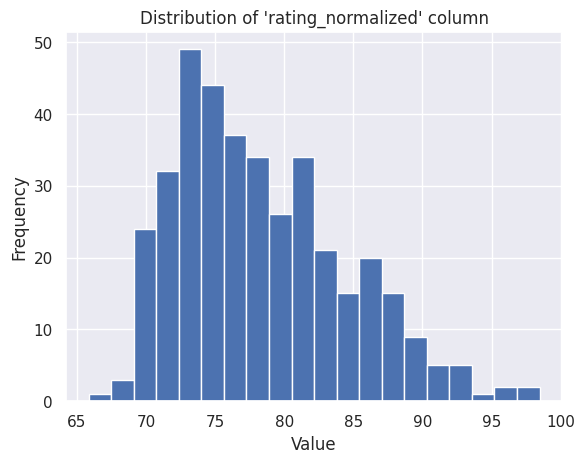

In [14]:
_season = 2022
_position = "F"
_situation = "all"

_col = "rating_normalized"

ax = (
    df_grouped
    .loc[
        (
            (df_grouped.season == _season) & 
            (df_grouped.position == _position) &
            (df_grouped.situation == _situation) 
        ),
        _col
    ]
    .plot(
        kind="hist", 
        bins=20,
        title=f"Distribution of '{_col}' column",
    )
)
ax.set_xlabel("Value")

## Results 

## TODO

- Zlepšit statistiku. 
- Zkusit vytvořit nějaké vizualizace/karty.
    - Podívat se na konkurenci a odpovědět si na následující otázky.
        - Co mi chybí? 
        - Co mohu udělat lépe?
        - Co se mi líbí/nelíbí?